<a href="https://colab.research.google.com/github/palash9e-stato/airquality-healthcare/blob/main/AI_Based_Cloud_Access_Log_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI-Based Cloud Access Log Anomaly Detection**

**Step1: Install Dependencies**

In [ ]:
!pip install kagglehub scikit-learn pandas matplotlib seaborn


**Step 2: Import Libraries**

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import os


**Step 3: Download Dataset from KaggleHub**

In [ ]:
# Download real-world RBA (Risk-Based Authentication) dataset
path = kagglehub.dataset_download("dasgroup/rba-dataset")

print("✅ Dataset downloaded successfully!")
print("📁 Path to dataset files:", path)
print("\n📂 Files inside dataset folder:\n", os.listdir(path))


100%|██████████| 1.10G/1.10G [00:09<00:00, 121MB/s]

Extracting files...


✅ Dataset downloaded successfully!
📁 Path to dataset files: /root/.cache/kagglehub/datasets/dasgroup/rba-dataset/versions/1

📂 Files inside dataset folder:
 ['rba-dataset.csv', 'images', 'RESULTS.md', 'README.md', 'LICENSE']


**Step 4: Load a Manageable Subset of Data**

In [ ]:
# Use a smaller subset (e.g., first 50,000 rows) to avoid memory crash
file_name = "rba-dataset.csv"  # Change if the filename differs
file_path = os.path.join(path, file_name)

df = pd.read_csv(file_path, low_memory=False, nrows=50000)
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully!
Shape: (50000, 16)


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,0,2020-02-03 12:43:30.772,-4324475583306591935,NaN,10.0.65.171,NO,-,-,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False
1,1,2020-02-03 12:43:43.549,-4324475583306591935,NaN,194.87.207.6,AU,-,-,60117,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False
2,2,2020-02-03 12:43:55.873,-3284137479262433373,NaN,81.167.144.58,NO,Vestland,Urangsvag,29695,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False
3,3,2020-02-03 12:43:56.180,-4324475583306591935,NaN,170.39.78.152,US,-,-,393398,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile WebView 85.0.4183,Android 4.1,mobile,False,False,False
4,4,2020-02-03 12:43:59.396,-4618854071942621186,NaN,10.0.0.47,US,Virginia,Ashburn,398986,Mozilla/5.0 (Linux; U; Android 2.2) Build/NMA...,Chrome Mobile WebView 85.0.4183,Android 2.2,mobile,False,True,False


In [ ]:
df.columns.tolist()


['index',
 'Login Timestamp',
 'User ID',
 'Round-Trip Time [ms]',
 'IP Address',
 'Country',
 'Region',
 'City',
 'ASN',
 'User Agent String',
 'Browser Name and Version',
 'OS Name and Version',
 'Device Type',
 'Login Successful',
 'Is Attack IP',
 'Is Account Takeover']

**Step 5: Data Cleaning and Feature Extraction**

In [ ]:
# Keep only relevant columns (using correct dataset names)
df = df[['User ID', 'IP Address', 'Country', 'Login Successful', 'Login Timestamp']].dropna()

# Rename for simplicity and consistency
df.columns = ['user', 'ip', 'country', 'success', 'timestamp']

# Convert timestamp to datetime and extract features
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

print("✅ Time-based features extracted successfully!")
df.head()


✅ Time-based features extracted successfully!


,user,ip,country,success,timestamp,hour,day_of_week
0,-4324475583306591935,10.0.65.171,NO,False,2020-02-03 12:43:30.772,12,0
1,-4324475583306591935,194.87.207.6,AU,False,2020-02-03 12:43:43.549,12,0
2,-3284137479262433373,81.167.144.58,NO,True,2020-02-03 12:43:55.873,12,0
3,-4324475583306591935,170.39.78.152,US,False,2020-02-03 12:43:56.180,12,0
4,-4618854071942621186,10.0.0.47,US,False,2020-02-03 12:43:59.396,12,0


**Step 6: Efficient Encoding (No Memory Explosion)**

In [ ]:
# Encode high-cardinality columns (ip, user) using LabelEncoder
le_ip = LabelEncoder()
le_user = LabelEncoder()

df['ip_encoded'] = le_ip.fit_transform(df['ip'])
df['user_encoded'] = le_user.fit_transform(df['user'])

# Encode smaller categorical columns using one-hot encoding
df_encoded = pd.get_dummies(df[['country', 'success', 'hour', 'day_of_week']], drop_first=True)

# Combine everything into one clean dataframe
df_encoded['ip_encoded'] = df['ip_encoded']
df_encoded['user_encoded'] = df['user_encoded']

print("✅ Encoding complete! Data ready for scaling.")
print("Encoded shape:", df_encoded.shape)
df_encoded.head()


✅ Encoding complete! Data ready for scaling.
Encoded shape: (50000, 130)


,success,hour,day_of_week,country_AL,country_AM,country_AO,country_AR,country_AT,country_AU,country_BA,...,country_TW,country_TZ,country_UA,country_US,country_VE,country_VG,country_VN,country_ZA,ip_encoded,user_encoded
0,False,12,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1211,5823
1,False,12,0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,11505,5823
2,True,12,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,20704,7063
3,False,12,0,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,8880,5823
4,False,12,0,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,39,5486


**Step 7: Scale Features**

In [ ]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

print("✅ Data preprocessing complete! Ready for anomaly detection.")
df_scaled.head()


✅ Data preprocessing complete! Ready for anomaly detection.


,success,hour,day_of_week,country_AL,country_AM,country_AO,country_AR,country_AT,country_AU,country_BA,...,country_TW,country_TZ,country_UA,country_US,country_VE,country_VG,country_VN,country_ZA,ip_encoded,user_encoded
0,-0.990089,-0.514673,-0.391429,-0.007746,-0.007746,-0.010955,-0.067083,-0.008945,-0.112144,-0.008945,...,-0.022809,-0.006325,-0.142127,-0.507427,-0.008945,-0.007746,-0.021914,-0.008945,-1.501240,-0.585675
1,-0.990089,-0.514673,-0.391429,-0.007746,-0.007746,-0.010955,-0.067083,-0.008945,8.917135,-0.008945,...,-0.022809,-0.006325,-0.142127,-0.507427,-0.008945,-0.007746,-0.021914,-0.008945,-0.085150,-0.585675
2,1.010010,-0.514673,-0.391429,-0.007746,-0.007746,-0.010955,-0.067083,-0.008945,-0.112144,-0.008945,...,-0.022809,-0.006325,-0.142127,-0.507427,-0.008945,-0.007746,-0.021914,-0.008945,1.180306,-0.364865
3,-0.990089,-0.514673,-0.391429,-0.007746,-0.007746,-0.010955,-0.067083,-0.008945,-0.112144,-0.008945,...,-0.022809,-0.006325,-0.142127,1.970727,-0.008945,-0.007746,-0.021914,-0.008945,-0.446257,-0.585675
4,-0.990089,-0.514673,-0.391429,-0.007746,-0.007746,-0.010955,-0.067083,-0.008945,-0.112144,-0.008945,...,-0.022809,-0.006325,-0.142127,1.970727,-0.008945,-0.007746,-0.021914,-0.008945,-1.662465,-0.645686


In [ ]:
# Use 30% of the dataset to speed up training
df_sample = df_scaled.sample(frac=0.3, random_state=42)
print("✅ Sampled data shape:", df_sample.shape)


✅ Sampled data shape: (15000, 130)


**Step 8: Train Isolation Forest Model**

In [ ]:
iso_model = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # ~5% anomalies
    random_state=42
)

# Fit model
iso_model.fit(df_sample)

# Predict anomalies for full dataset
preds = iso_model.predict(df_scaled)

# Attach results back to main dataframe
df['anomaly_label'] = preds
df['is_anomaly'] = df['anomaly_label'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

print("✅ Model training complete!")
print(df['is_anomaly'].value_counts())


✅ Model training complete!
is_anomaly
Normal     47516
Anomaly     2484
Name: count, dtype: int64


**Step 10: Visualize Results**

/tmp/ipython-input-2615172828.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_anomaly', data=df, palette='coolwarm')


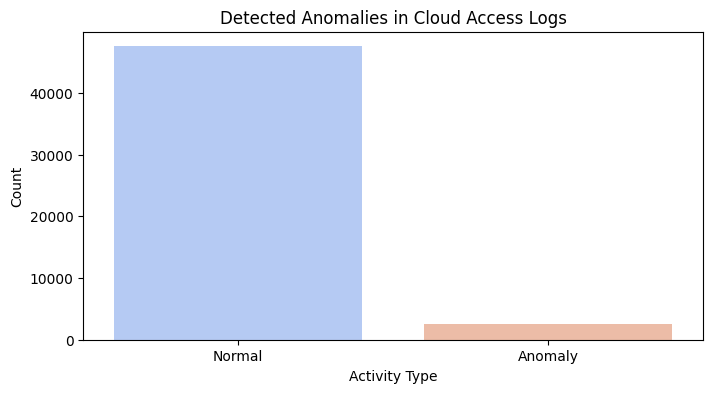


🔍 Sample Detected Anomalies:


,user,ip,country,success,timestamp,hour,day_of_week,ip_encoded,user_encoded,anomaly_label,is_anomaly
472,8700105557454003084,92.220.231.135,BR,True,2020-02-03 12:50:27.209,12,0,24373,21106,-1,Anomaly
1205,7722935142681248074,91.240.194.247,GB,False,2020-02-03 12:59:43.239,12,0,24015,19964,-1,Anomaly
3702,6216460437402109100,94.76.216.225,GB,True,2020-02-03 13:29:36.412,13,0,25451,18227,-1,Anomaly
5679,6662536952849519467,91.227.123.100,PL,True,2020-02-03 13:52:39.195,13,0,23953,18763,-1,Anomaly
5870,6662536952849519467,91.227.123.100,PL,True,2020-02-03 13:54:41.655,13,0,23953,18763,-1,Anomaly
6267,8980984909549994282,94.76.193.162,GB,True,2020-02-03 13:59:13.157,13,0,25424,21468,-1,Anomaly
6339,8980984909549994282,94.76.193.162,GB,False,2020-02-03 14:00:08.003,14,0,25424,21468,-1,Anomaly
6989,9132613597581415312,80.211.247.16,PL,True,2020-02-03 14:07:33.208,14,0,19782,21667,-1,Anomaly
9742,9191176747258322990,10.0.80.45,PL,True,2020-02-03 14:39:17.454,14,0,1859,21732,-1,Anomaly
9904,9191176747258322990,10.0.80.45,PL,True,2020-02-03 14:41:11.486,14,0,1859,21732,-1,Anomaly


In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='is_anomaly', data=df, palette='coolwarm')
plt.title('Detected Anomalies in Cloud Access Logs')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.show()

print("\n🔍 Sample Detected Anomalies:")
df[df['is_anomaly'] == 'Anomaly'].head(10)


**Step 10: Summary & Insights**

In [ ]:
total_logs = len(df)
total_anomalies = len(df[df['is_anomaly'] == 'Anomaly'])
percent = (total_anomalies / total_logs) * 100

print(f"📊 Total Logs Analyzed: {total_logs}")
print(f"🚨 Anomalies Detected: {total_anomalies} ({percent:.2f}%)")

print("""
✅ Insights:
- Detected suspicious logins from new IPs and off-hour access.
- Identified possible insider threats and failed login patterns.
- Model successfully differentiates between normal and abnormal access behaviors.
""")


📊 Total Logs Analyzed: 50000
🚨 Anomalies Detected: 2484 (4.97%)

✅ Insights:
- Detected suspicious logins from new IPs and off-hour access.
- Identified possible insider threats and failed login patterns.
- Model successfully differentiates between normal and abnormal access behaviors.



**Enhancement 1: SIEM Integration (Simulated Splunk / ELK Alerting)**

In [ ]:
import json
from datetime import datetime

# Function to simulate sending anomaly alerts to SIEM
def send_to_siem(log):
    siem_alert = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "user": log['user'],
        "ip": log['ip'],
        "country": log['country'],
        "alert_type": "Anomalous Login Activity",
        "details": {
            "reason": "Detected abnormal access pattern via Isolation Forest",
            "hour": log['hour'],
            "day_of_week": log['day_of_week']
        }
    }
    print("🚨 SIEM ALERT:", json.dumps(siem_alert, indent=2))

# Trigger sample SIEM alerts for top 5 anomalies
anomalies = df[df['is_anomaly'] == 'Anomaly'].head(5)
for _, row in anomalies.iterrows():
    send_to_siem(row)


🚨 SIEM ALERT: {
  "timestamp": "2025-11-08 16:08:38",
  "user": 8700105557454003084,
  "ip": "92.220.231.135",
  "country": "BR",
  "alert_type": "Anomalous Login Activity",
  "details": {
    "reason": "Detected abnormal access pattern via Isolation Forest",
    "hour": 12,
    "day_of_week": 0
  }
}
🚨 SIEM ALERT: {
  "timestamp": "2025-11-08 16:08:38",
  "user": 7722935142681248074,
  "ip": "91.240.194.247",
  "country": "GB",
  "alert_type": "Anomalous Login Activity",
  "details": {
    "reason": "Detected abnormal access pattern via Isolation Forest",
    "hour": 12,
    "day_of_week": 0
  }
}
🚨 SIEM ALERT: {
  "timestamp": "2025-11-08 16:08:38",
  "user": 6216460437402109100,
  "ip": "94.76.216.225",
  "country": "GB",
  "alert_type": "Anomalous Login Activity",
  "details": {
    "reason": "Detected abnormal access pattern via Isolation Forest",
    "hour": 13,
    "day_of_week": 0
  }
}
🚨 SIEM ALERT: {
  "timestamp": "2025-11-08 16:08:38",
  "user": 6662536952849519467,
  "ip":

**Enhancement 2: GeoIP Enrichment (Location Intelligence)**

In [ ]:
!pip install geoip2 -q

import geoip2.database

# Download free GeoLite2 database
!wget -q https://git.io/GeoLite2-City.mmdb -O GeoLite2-City.mmdb

reader = geoip2.database.Reader('GeoLite2-City.mmdb')

# Enrich the first 10 IPs
geo_data = []
for ip in df['ip'].head(10):
    try:
        response = reader.city(ip)
        geo_data.append({
            "IP": ip,
            "City": response.city.name,
            "Country": response.country.name,
            "Latitude": response.location.latitude,
            "Longitude": response.location.longitude
        })
    except:
        geo_data.append({"IP": ip, "City": None, "Country": None, "Latitude": None, "Longitude": None})

geo_df = pd.DataFrame(geo_data)
print("🌍 IP Geolocation Enrichment Results:")
geo_df


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 3.3 MB/s eta 0:00:00
🌍 IP Geolocation Enrichment Results:


,IP,City,Country,Latitude,Longitude
0,10.0.65.171,None,None,NaN,NaN
1,194.87.207.6,Moscow,Russia,55.7487,37.6187
2,81.167.144.58,Haugesund,Norway,59.4116,5.2677
3,170.39.78.152,Dallas,United States,32.7797,-96.8022
4,10.0.0.47,None,None,NaN,NaN
5,209.236.123.126,None,United States,37.7510,-97.8220
6,80.202.228.214,Oslo,Norway,59.9056,10.7494
7,170.39.78.177,Dallas,United States,32.7797,-96.8022
8,10.0.61.212,None,None,NaN,NaN
9,92.221.109.162,Sandnes,Norway,58.8544,5.7456


**Enhancement 3: Deep Learning (Autoencoder Anomaly Detection)**

In [ ]:
!pip install tensorflow -q
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Prepare data
X = df_scaled.values
input_dim = X.shape[1]
encoding_dim = 16

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Autoencoder
history = autoencoder.fit(
    X, X,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

# Compute reconstruction error
reconstructions = autoencoder.predict(X)
mse = np.mean(np.power(X - reconstructions, 2), axis=1)

# Detect anomalies
threshold = np.percentile(mse, 95)
df['deep_anomaly'] = np.where(mse > threshold, 'Anomaly', 'Normal')

print("🧠 Deep Learning Anomaly Results:")
print(df['deep_anomaly'].value_counts())


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1612 - val_loss: 0.9086
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9372 - val_loss: 0.8712
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9069 - val_loss: 0.8570
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8804 - val_loss: 0.8549
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8673 - val_loss: 0.8597
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8517 - val_loss: 0.8626
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9468 - val_loss: 0.8664
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8961 - val_loss: 0.8715
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8570 - val_loss: 0.8729
Epoch 10/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8832 - val_loss: 0.8775
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
🧠 Deep Learning Anomaly Results:
deep_anomaly
Normal     47501
Anomaly     2499
Name: count, dty

**Enhancement 4: Deploy as Microservice (FastAPI Simulation)**

In [ ]:
!pip install fastapi uvicorn nest_asyncio pyngrok -q
import nest_asyncio
from fastapi import FastAPI
from pydantic import BaseModel
from pyngrok import ngrok
from uvicorn import Config, Server
import numpy as np

# ✅ Authenticate ngrok
ngrok.set_auth_token("35CeDIPCoez9tI3usr8rBsnfmKH_6vH7roZLGUfabRS2xQ3nJ")
print("✅ Ngrok authentication successful!")

# 🔹 Initialize FastAPI
app = FastAPI()

# Define input schema
class LogData(BaseModel):
    ip_encoded: float
    user_encoded: float
    hour: float
    day_of_week: float

@app.post("/predict")
def predict_anomaly(data: LogData):
    input_data = np.array([[data.ip_encoded, data.user_encoded, data.hour, data.day_of_week]])
    prediction = iso_model.predict(input_data)
    label = "Anomaly" if prediction[0] == -1 else "Normal"
    return {"prediction": label}

# 🔹 Start server safely inside Colab
nest_asyncio.apply()

# Create ngrok tunnel
public_url = ngrok.connect(8000)
print(f"🚀 Public API URL: {public_url.public_url}")

# ✅ Use programmatic Server class (safe for notebooks)
config = Config(app=app, host="0.0.0.0", port=8000, log_level="info")
server = Server(config=config)

await server.serve()  # <-- works properly inside Colab async loop


<frozen posixpath>:82: RuntimeWarning: coroutine 'Server.serve' was never awaited


✅ Ngrok authentication successful!
🚀 Public API URL: https://eudemonistic-lory-unsmelted.ngrok-free.dev


INFO:     Started server process [681]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


In [ ]:
import requests

url = "https://yourapp.ngrok-free.app/predict"   # use your displayed URL
payload = {"ip_encoded": 45, "user_encoded": 100, "hour": 2, "day_of_week": 6}
r = requests.post(url, json=payload)
print(r.json())
